# FlashAttention API

This notebook demonstrates the native programming interfaces for FlashAttention-enabled topic modeling using Transformers and Sentence-Transformers libraries, along with our custom wrapper layer.

## Description

This notebook explores:
- Native Transformers library API for loading models and encoding text
- Native Sentence-Transformers library API for simplified text encoding
- FlashAttention integration with PyTorch 2.0+ via Scaled_dot_product_attention
- Custom wrapper functions from flash_attn_utils.py for topic modeling workflows

For detailed API documentation, see flash_attn.API.md.

## Requirements

- PyTorch 2.0+ (for FlashAttention support via scaled_dot_product_attention)
- Transformers library from Hugging Face
- Sentence-Transformers library
- CUDA-compatible GPU (optional, for FlashAttention benefits; works on CPU but slower)

All dependencies are installed via Docker. See README.md for Docker setup instructions.

## Citations

- FlashAttention: Dao et al. (2022). "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness." https://arxiv.org/abs/2205.14135
- E5 Embeddings: Wang et al. (2022). "Text Embeddings by Weakly-Supervised Contrastive Pre-training." https://arxiv.org/abs/2212.03533
- Transformers: Wolf et al. (2020). "Transformers: State-of-the-Art Natural Language Processing." https://arxiv.org/abs/1910.03771


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/UmdTask39_Fall2025_flash_attn_Topic_Modeling_of_Scientific_Papers")
!pwd
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Teq6RajUlyOzifNCC5VGPdKdgOVx6jId/UmdTask39_Fall2025_flash_attn_Topic_Modeling_of_Scientific_Papers
data		      flash_attn.API.md			 __pycache__
docker-compose.yml    flash_attn.example.md		 README.md
Dockerfile	      flash_attn.example_modified.ipynb  requirements.txt
flash_attn.API.ipynb  flash_attn_utils.py


In [2]:
import logging
import os
import warnings

import numpy as np
import pandas as pd
import torch

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

import flash_attn_utils

# Initialize logger.
_LOG = logging.getLogger(__name__)

# Configure environment variables.
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")

# Configure warnings.
warnings.filterwarnings("ignore")

# Configure logging.
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")

# Verify PyTorch version and device availability.
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
# Check FlashAttention availability (requires CUDA for actual FlashAttention).
has_flash, flash_msg = flash_attn_utils.check_flash_attention_support()
print(f"\nFlashAttention support: {has_flash}")
print(f"Status: {flash_msg}")


PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: NVIDIA L4

FlashAttention support: True
Status: FlashAttention available via scaled_dot_product_attention (CUDA)


## Native Transformers API

The Transformers library from Hugging Face provides access to thousands of pre-trained models. This section demonstrates how to use the native API directly.


### Load Model and Tokenizer

Use `AutoTokenizer` and `AutoModel` to load a pre-trained model from Hugging Face.


In [3]:
# Load model and tokenizer using native Transformers API.
# Use the same model as the main example notebook for consistency.
model_name = "intfloat/e5-large-v2"

# Load tokenizer and model using AutoTokenizer and AutoModel.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to appropriate device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"Loaded model: {model_name}")
print(f"Model device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loaded model: intfloat/e5-large-v2
Model device: cuda
Model parameters: 335,141,888


### Encode Text with Native API

Manually encode text using tokenization, batching, and embedding extraction.


In [4]:
# Define sample texts to encode.
sample_texts = [
    "Machine learning is a subset of artificial intelligence.",
    "Deep learning uses neural networks with multiple layers.",
    "Natural language processing enables computers to understand text.",
]

# Tokenize texts using the tokenizer.
encoded = tokenizer(
    sample_texts,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
# Move encoded inputs to the same device as the model.
encoded = {k: v.to(device) for k, v in encoded.items()}

# Generate embeddings using the model.
with torch.no_grad():
    # Forward pass through the model.
    outputs = model(**encoded)
    last_hidden_state = outputs.last_hidden_state

    # Apply mean pooling to get sentence embeddings.
    attention_mask = encoded["attention_mask"].unsqueeze(-1)
    summed = (last_hidden_state * attention_mask).sum(dim=1)
    lengths = attention_mask.sum(dim=1).clamp(min=1)
    embeddings = (summed / lengths).cpu().numpy()

print(f"Input texts: {len(sample_texts)}")
print(f"Embedding shape: {embeddings.shape}")
print(f"Embedding dimensionality: {embeddings.shape[1]}")
print(f"\nFirst embedding (first 10 values):\n{embeddings[0][:10]}")


Input texts: 3
Embedding shape: (3, 1024)
Embedding dimensionality: 1024

First embedding (first 10 values):
[ 0.19600525 -1.9047805   0.03439268 -1.0021043  -1.0376065   0.6411652
 -1.3795992  -0.42497027 -0.8765536   0.75138545]


### FlashAttention Integration

Verify that PyTorch 2.0+ is using FlashAttention automatically when available.


In [5]:
# Check if scaled_dot_product_attention is available (PyTorch 2.0+).
has_sdpa = hasattr(torch.nn.functional, "scaled_dot_product_attention")

if has_sdpa:
    print("PyTorch 2.0+ detected: scaled_dot_product_attention available.")
    print("Models using this will automatically benefit from FlashAttention on CUDA.")
    # Verify model is configured correctly.
    print(f"\nModel attention type: {type(model.encoder.layer[0].attention.self)}")
else:
    print("PyTorch < 2.0: FlashAttention not available via scaled_dot_product_attention.")
    print("Upgrade to PyTorch 2.0+ for automatic FlashAttention support.")

# Note: Explicit FlashAttention usage would require model config modification.
# This is typically handled automatically by the model's forward method in PyTorch 2.0+.


PyTorch 2.0+ detected: scaled_dot_product_attention available.
Models using this will automatically benefit from FlashAttention on CUDA.

Model attention type: <class 'transformers.models.bert.modeling_bert.BertSdpaSelfAttention'>


## Native Sentence-Transformers API

Sentence-Transformers provides models optimized for semantic similarity tasks and simplifies the encoding process.


In [6]:
# Load model using Sentence-Transformers API.
st_model = SentenceTransformer(model_name)

print(f"Loaded Sentence-Transformer: {model_name}")
print(f"Max sequence length: {st_model.max_seq_length}")
print(f"Embedding dimension: {st_model.get_sentence_embedding_dimension()}")


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Loaded Sentence-Transformer: intfloat/e5-large-v2
Max sequence length: 512
Embedding dimension: 1024


### Encode with Sentence-Transformers

Use the simplified Sentence-Transformers API for encoding text.


In [7]:
# Encode texts using Sentence-Transformers API.
st_embeddings = st_model.encode(sample_texts, show_progress_bar=False)

print(f"Embedding shape: {st_embeddings.shape}")
print(f"First embedding (first 10 values):\n{st_embeddings[0][:10]}")

# Compare with manual encoding from native Transformers API.
print(f"\nEmbeddings match (native Transformers vs Sentence-Transformers):")
print(f"Shape match: {embeddings.shape == st_embeddings.shape}")
print(f"Close values: {np.allclose(embeddings, st_embeddings, atol=1e-3)}")


Embedding shape: (3, 1024)
First embedding (first 10 values):
[ 0.00838643 -0.08149939  0.00147155 -0.04287679 -0.04439582  0.02743338
 -0.05902858 -0.0181831  -0.03750489  0.03214935]

Embeddings match (native Transformers vs Sentence-Transformers):
Shape match: True
Close values: False


## Custom Wrapper Layer

The `flash_attn_utils.py` module provides wrapper functions that simplify common workflows.


### Load and Preprocess arXiv Data

Use the `load_and_preprocess_arxiv()` function to handle streaming JSONL files and text preprocessing. This is typically the first step in a topic modeling workflow.

**Note**: This requires the arXiv metadata file. We'll demonstrate with a small example if the file is not available.


In [19]:
# Example: Load arXiv data (if file exists).
# Use project-relative path (works in Docker and Colab when cwd is project root).
from pathlib import Path
from IPython.display import display

arxiv_path = Path("data/arxiv-metadata-oai-snapshot.json")

# Optional: If running in Docker with backward-compatibility mount, check alternative path.
alt_path = Path("data/arxiv-metadata-oai-snapshot.json")

import os
if arxiv_path.exists():
    arxiv_path_str = str(arxiv_path)
elif alt_path.exists():
    arxiv_path_str = str(alt_path)
else:
    arxiv_path_str = None

if arxiv_path_str:
    # Load a small subset for demonstration.
    df = flash_attn_utils.load_and_preprocess_arxiv(
        arxiv_path_str,
        max_docs=100,  # Small subset for API demo.
        min_abstract_len=50
    )

    print(f"Loaded {len(df)} documents.")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few records:")
    display(df.head(3))

    print(f"\nText preprocessing example:")
    if len(df) > 0:
        print(f"Original title: {df.iloc[0]['title']}")
        print(f"Processed text (first 200 chars): {df.iloc[0]['text'][:200]}...")
else:
    print("arXiv file not found.")
    print("Skipping data loading demo. See flash_attn.example.ipynb for complete example.")


Loaded 100 documents.

Columns: ['id', 'title', 'abstract', 'categories', 'text']

First few records:


,id,title,abstract,categories,text
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbati...,hep-ph,calculation of prompt diphoton production cros...
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,sparsity-certifying graph decompositions. we d...
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is describe...,physics.gen-ph,the evolution of the earth-moon system based o...



Text preprocessing example:
Original title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
Processed text (first 200 chars): calculation of prompt diphoton production cross sections at tevatron and lhc energies. a fully differential calculation in perturbative quantum chromodynamics is presented for the production of massiv...


### Load Encoder with Wrapper

Use the `load_encoder()` function from `flash_attn_utils.py` to load a model with FlashAttention support.


In [9]:
# Load encoder using wrapper function with FlashAttention enabled (default).
tokenizer_wrapper, model_wrapper, device_wrapper = flash_attn_utils.load_encoder(
    model_name,
    use_flash_attention=True  # Enable FlashAttention when available.
)

print(f"Wrapper loaded model: {model_name}")
print(f"Wrapper device: {device_wrapper}")
print(f"Tokenizer type: {type(tokenizer_wrapper).__name__}")
print(f"Model type: {type(model_wrapper).__name__}")

# Note: FlashAttention status is logged automatically during model loading.


Wrapper loaded model: intfloat/e5-large-v2
Wrapper device: cuda
Tokenizer type: BertTokenizerFast
Model type: BertModel


### Encode Texts with Wrapper

Use the `encode_texts()` function to encode texts with automatic batching and progress tracking.


In [10]:
# Check FlashAttention availability using wrapper function.
has_flash, flash_msg = flash_attn_utils.check_flash_attention_support()
print(f"FlashAttention check:")
print(f"  Available: {has_flash}")
print(f"  Status: {flash_msg}")

# Encode texts using wrapper function.
wrapper_embeddings = flash_attn_utils.encode_texts(
    sample_texts,
    tokenizer_wrapper,
    model_wrapper,
    device_wrapper,
    batch_size=32,
    max_length=256
)

print(f"\nWrapper embedding shape: {wrapper_embeddings.shape}")
print(f"First embedding (first 10 values):\n{wrapper_embeddings[0][:10]}")

# Compare with native Sentence-Transformers.
print(f"\nEmbeddings match (wrapper vs Sentence-Transformers):")
print(f"Shape match: {wrapper_embeddings.shape == st_embeddings.shape}")
print(f"Close values: {np.allclose(wrapper_embeddings, st_embeddings, atol=1e-2)}")


FlashAttention check:
  Available: True
  Status: FlashAttention available via scaled_dot_product_attention (CUDA)


Encoding: 100%|██████████| 1/1 [00:00<00:00, 53.06it/s]


Wrapper embedding shape: (3, 1024)
First embedding (first 10 values):
[ 0.19600525 -1.9047805   0.03439268 -1.0021043  -1.0376065   0.6411652
 -1.3795992  -0.42497027 -0.8765536   0.75138545]

Embeddings match (wrapper vs Sentence-Transformers):
Shape match: True
Close values: False


## Clustering and Topic Extraction

Use wrapper functions to cluster embeddings and extract topic labels.


In [11]:
# Create sample embeddings for clustering demonstration.
demo_texts = [
    "Machine learning algorithms improve with more data.",
    "Deep neural networks have multiple hidden layers.",
    "Quantum computing uses quantum mechanical phenomena.",
    "Quantum entanglement enables faster computation.",
    "The Sun is a star in our solar system.",
    "Galaxies contain billions of stars and planets.",
    "Particle physics studies fundamental particles.",
    "The Higgs boson was discovered at CERN.",
] * 3  # 24 texts total.

# Encode demo texts using wrapper function.
demo_embeddings = flash_attn_utils.encode_texts(
    demo_texts,
    tokenizer_wrapper,
    model_wrapper,
    device_wrapper,
    batch_size=16,
    max_length=256
)

print(f"Demo embeddings shape: {demo_embeddings.shape}")

# Cluster embeddings using K-Means.
labels, kmeans_model = flash_attn_utils.cluster_kmeans(demo_embeddings, k=3, random_state=42)

print(f"\nClustering results:")
print(f"Number of clusters: {kmeans_model.n_clusters}")
print(f"Cluster labels: {labels}")
print(f"\nDocuments per cluster:")
for i in range(kmeans_model.n_clusters):
    count = np.sum(labels == i)
    print(f"  Cluster {i}: {count} documents")


Encoding: 100%|██████████| 2/2 [00:00<00:00, 33.44it/s]

Demo embeddings shape: (24, 1024)

Clustering results:
Number of clusters: 3
Cluster labels: [0 0 1 0 2 2 1 1 0 0 1 0 2 2 1 1 0 0 1 0 2 2 1 1]

Documents per cluster:
  Cluster 0: 9 documents
  Cluster 1: 9 documents
  Cluster 2: 6 documents


### Topic Labeling with TF-IDF

The `describe_topics_tfidf()` function extracts topic keywords using TF-IDF analysis.


In [12]:
# Extract topic keywords
topics = flash_attn_utils.describe_topics_tfidf(demo_texts, labels, top_k=5)

print("Topic keywords extracted:")
for cluster_id, keywords in sorted(topics.items()):
    print(f"\nCluster {cluster_id}:")
    for keyword, score in keywords:
        print(f"  - {keyword}: {score:.4f}")

# Show example texts per cluster
print("\n\nExample texts per cluster:")
for cluster_id in sorted(topics.keys()):
    cluster_indices = np.where(labels == cluster_id)[0][:2]  # Show first 2
    print(f"\nCluster {cluster_id} examples:")
    for idx in cluster_indices:
        print(f"  - {demo_texts[idx][:60]}...")


Topic keywords extracted:

Cluster 0:
  - quantum: 0.3333
  - the: 0.0000

Cluster 1:
  - the: 0.3333
  - quantum: 0.3333

Cluster 2:
  - the: 0.5000
  - quantum: 0.0000


Example texts per cluster:

Cluster 0 examples:
  - Machine learning algorithms improve with more data....
  - Deep neural networks have multiple hidden layers....

Cluster 1 examples:
  - Quantum computing uses quantum mechanical phenomena....
  - Particle physics studies fundamental particles....

Cluster 2 examples:
  - The Sun is a star in our solar system....
  - Galaxies contain billions of stars and planets....


### Dimensionality Reduction for Visualization

The `reduce_2d()` function projects high-dimensional embeddings to 2D for visualization.


UMAP reduction successful
2D coordinates shape: (24, 2)


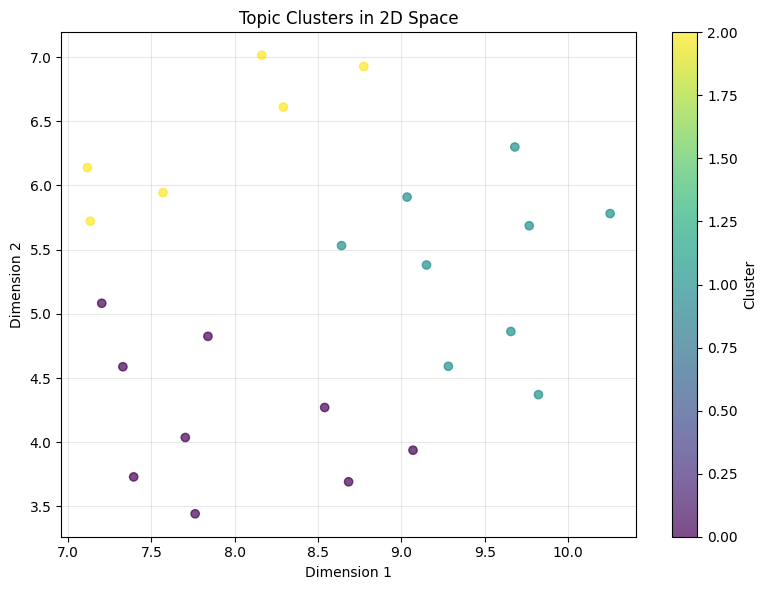


Clusters visualized: 3 distinct topics


In [13]:
# Reduce to 2D for visualization
try:
    coords_2d = flash_attn_utils.reduce_2d(demo_embeddings, method="umap", random_state=42)
    print("UMAP reduction successful")
    print(f"2D coordinates shape: {coords_2d.shape}")
except Exception as e:
    print(f"UMAP failed: {e}")
    print("Falling back to t-SNE...")
    coords_2d = flash_attn_utils.reduce_2d(demo_embeddings, method="tsne", random_state=42)
    print(f"t-SNE coordinates shape: {coords_2d.shape}")

# Visualize clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Topic Clusters in 2D Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nClusters visualized: {kmeans_model.n_clusters} distinct topics")


## 6. Performance Benchmarking

Our wrapper provides a benchmarking function to measure encoding performance and FlashAttention benefits.


### Benchmark Encoding Performance

The `benchmark_encoding()` function measures throughput and provides FlashAttention status.


In [14]:
# Benchmark encoding performance
benchmark_texts = sample_texts * 20  # 60 texts for benchmarking

benchmark_results = flash_attn_utils.benchmark_encoding(
    benchmark_texts,
    tokenizer_wrapper,
    model_wrapper,
    device_wrapper,
    batch_size=16,
    max_length=256,
    warmup=1,
    trials=3
)

print("Benchmark Results:")
print("=" * 60)
for key, value in benchmark_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")
print("=" * 60)

print("\nFlashAttention Benefits:")
if benchmark_results["flash_attention_available"]:
    print(" FlashAttention is enabled - expect 2-4x speedup and linear memory")
else:
    print("FlashAttention not available - running with standard attention")
    print(f"Reason: {benchmark_results['flash_attention_status']}")


Encoding: 100%|██████████| 4/4 [00:00<00:00, 54.43it/s]

Benchmark Results:
avg_time_seconds: 0.0758
throughput_docs_per_sec: 791.8795
num_texts: 60
batch_size: 16
flash_attention_available: True
flash_attention_status: FlashAttention available via scaled_dot_product_attention (CUDA)
device: cuda

FlashAttention Benefits:
 FlashAttention is enabled - expect 2-4x speedup and linear memory


## Summary

This notebook demonstrated:

1. **Native Transformers API**: Direct usage of AutoTokenizer and AutoModel
2. **FlashAttention Integration**: Automatic support via PyTorch 2.0+
3. **Native Sentence-Transformers API**: Simplified encoding interface
4. **Our Wrapper Layer**: Functions that simplify common workflows:
   - load_and_preprocess_arxiv(): Data loading and preprocessing (first step in workflow)
   - load_encoder(): Automatic device detection and model loading
   - encode_texts(): Batch encoding with progress tracking
   - cluster_kmeans(): Topic clustering from embeddings
   - describe_topics_tfidf(): Topic keyword extraction
   - reduce_2d(): Dimensionality reduction for visualization
   - check_flash_attention_support(): FlashAttention availability checking
   - benchmark_encoding(): Performance measurement and FlashAttention benefits

**Key Benefits of Our Wrapper**:
- Simplified API for common operations
- Automatic device management (CUDA/MPS/CPU)
- Progress tracking for long-running operations
- Consistent interface across different tasks
- FlashAttention optimization when available

**Next Steps**:
- See `flash_attn.example.ipynb` for a complete end-to-end application
- Read `flash_attn.API.md` for detailed API documentation
